**注意：1.每一步特征构建或预处理可逆； 2.特征构建后方便组合 3.增删数据要慎重，最终要是可逆；4.将train和test放在一起处理；5.对每一步特征处理的结果进行说明**

# KaggleRossmanStoreSales

## 准备工作


In [4]:
import pandas as pd
from pandas import Series, DataFrame
import itertools
import numpy as np
from datetime import datetime, date
from IPython.display import display
from datetime import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
import math

%matplotlib inline

In [43]:
seed = 12

### 评价指标

选择RMSPE作为评价指标，定义为：

$RMSPE=\sqrt{\frac{1}{n}\sum_{i=1}^N(\frac{y_i-\hat{y_i}}{y_i})^2} $




In [2]:
# 构建评价指标
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

# xgboost中的rmpse
def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

### 读取数据

In [3]:
train = pd.read_csv('./参考资料/kaggle-rossman-store-sales/input/train.csv', dtype = {'StateHoliday':str}, parse_dates=['Date'], date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))
store = pd.read_csv('./参考资料/kaggle-rossman-store-sales/input/store.csv', dtype = {'PromoInterval':str, 'CompetitionOpenSinceYear':str, 'CompetitionOpenSinceMonth':str})
test = pd.read_csv('./参考资料/kaggle-rossman-store-sales/input/test.csv', dtype = {'PromoInterval':str, 'CompetitionOpenSinceYear':str, 'CompetitionOpenSinceMonth':str}, parse_dates=['Date'],date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

## 特征工程


**1.将train和test合并**

方便对两个数据集进行同样的处理，同时可以避免一些错误。比如：单独对test数据集进行onehot处理时时少两列：'StateHoliday_b', 'StateHoliday_c'

In [4]:
train['Insample'] = 1
test['Insample'] = 0

In [5]:
# 合并train和test
all_data = pd.concat([train, test])

> Attention：all_data新增特征：“Insample”；通过该字段来区分train和test

**2.删除明显异常的数据**

删除Open = 1, Sales =0的数据

In [6]:
sub_all_data = all_data.loc[~((all_data['Open'] == 1) & (all_data['Sales'] == 0))]

In [7]:
print("删除之前行数为：", len(all_data))
print("删除之后行数为：", len(sub_all_data))

删除之前行数为： 1058297
删除之后行数为： 1058243


> Attention:处理后数据集为sub_all_data，一共删除了54行数据。说明异常数据点很少，属于正常范围

**3.对类别特征进行one-hot处理**

train进行该处理的字段有：'StateHoliday'

In [8]:
display(sub_all_data.StateHoliday.unique())

array(['0', 'a', 'b', 'c'], dtype=object)

In [9]:
sub_all_data = pd.get_dummies(sub_all_data, columns=['StateHoliday'])

> Attention：sub_all_data新增特征：'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'

**4.根据Date构造特征**


In [10]:
Date = 'Date'

sub_all_data['Day'] = pd.Index(sub_all_data[Date]).day
sub_all_data['Week'] = pd.Index(sub_all_data[Date]).week
sub_all_data['Month'] = pd.Index(sub_all_data[Date]).month
sub_all_data['Year'] = pd.Index(sub_all_data[Date]).year
sub_all_data['DayOfYear'] = pd.Index(sub_all_data[Date]).dayofyear

> Attention: sub_all_data新增特征：'Day', 'Week', 'Month', 'Year', 'DayOfYear'

**5.把Date日期转化为数值作为特征**

In [11]:
sub_all_data['DateInt'] = sub_all_data['Date'].astype(np.int64)

> Attention: sub_all_data新增特征：'DateInt'

**6.标记sub_all_data中可能的异常值**

In [12]:
# 值得学习，删除了偏差大的Saless数据，再理解一下
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        #将points变为array
        points = points[:,None]
    # 取中位数
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [13]:
for i in sub_all_data['Store'].unique():
    sub_all_data.loc[(sub_all_data['Insample'] == 1) & (sub_all_data['Store'] == i) & (sub_all_data['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(sub_all_data.loc[(sub_all_data['Insample'] == 1) & (sub_all_data['Store'] == i) & (sub_all_data['Open'] == 1)]['Sales'], 3)

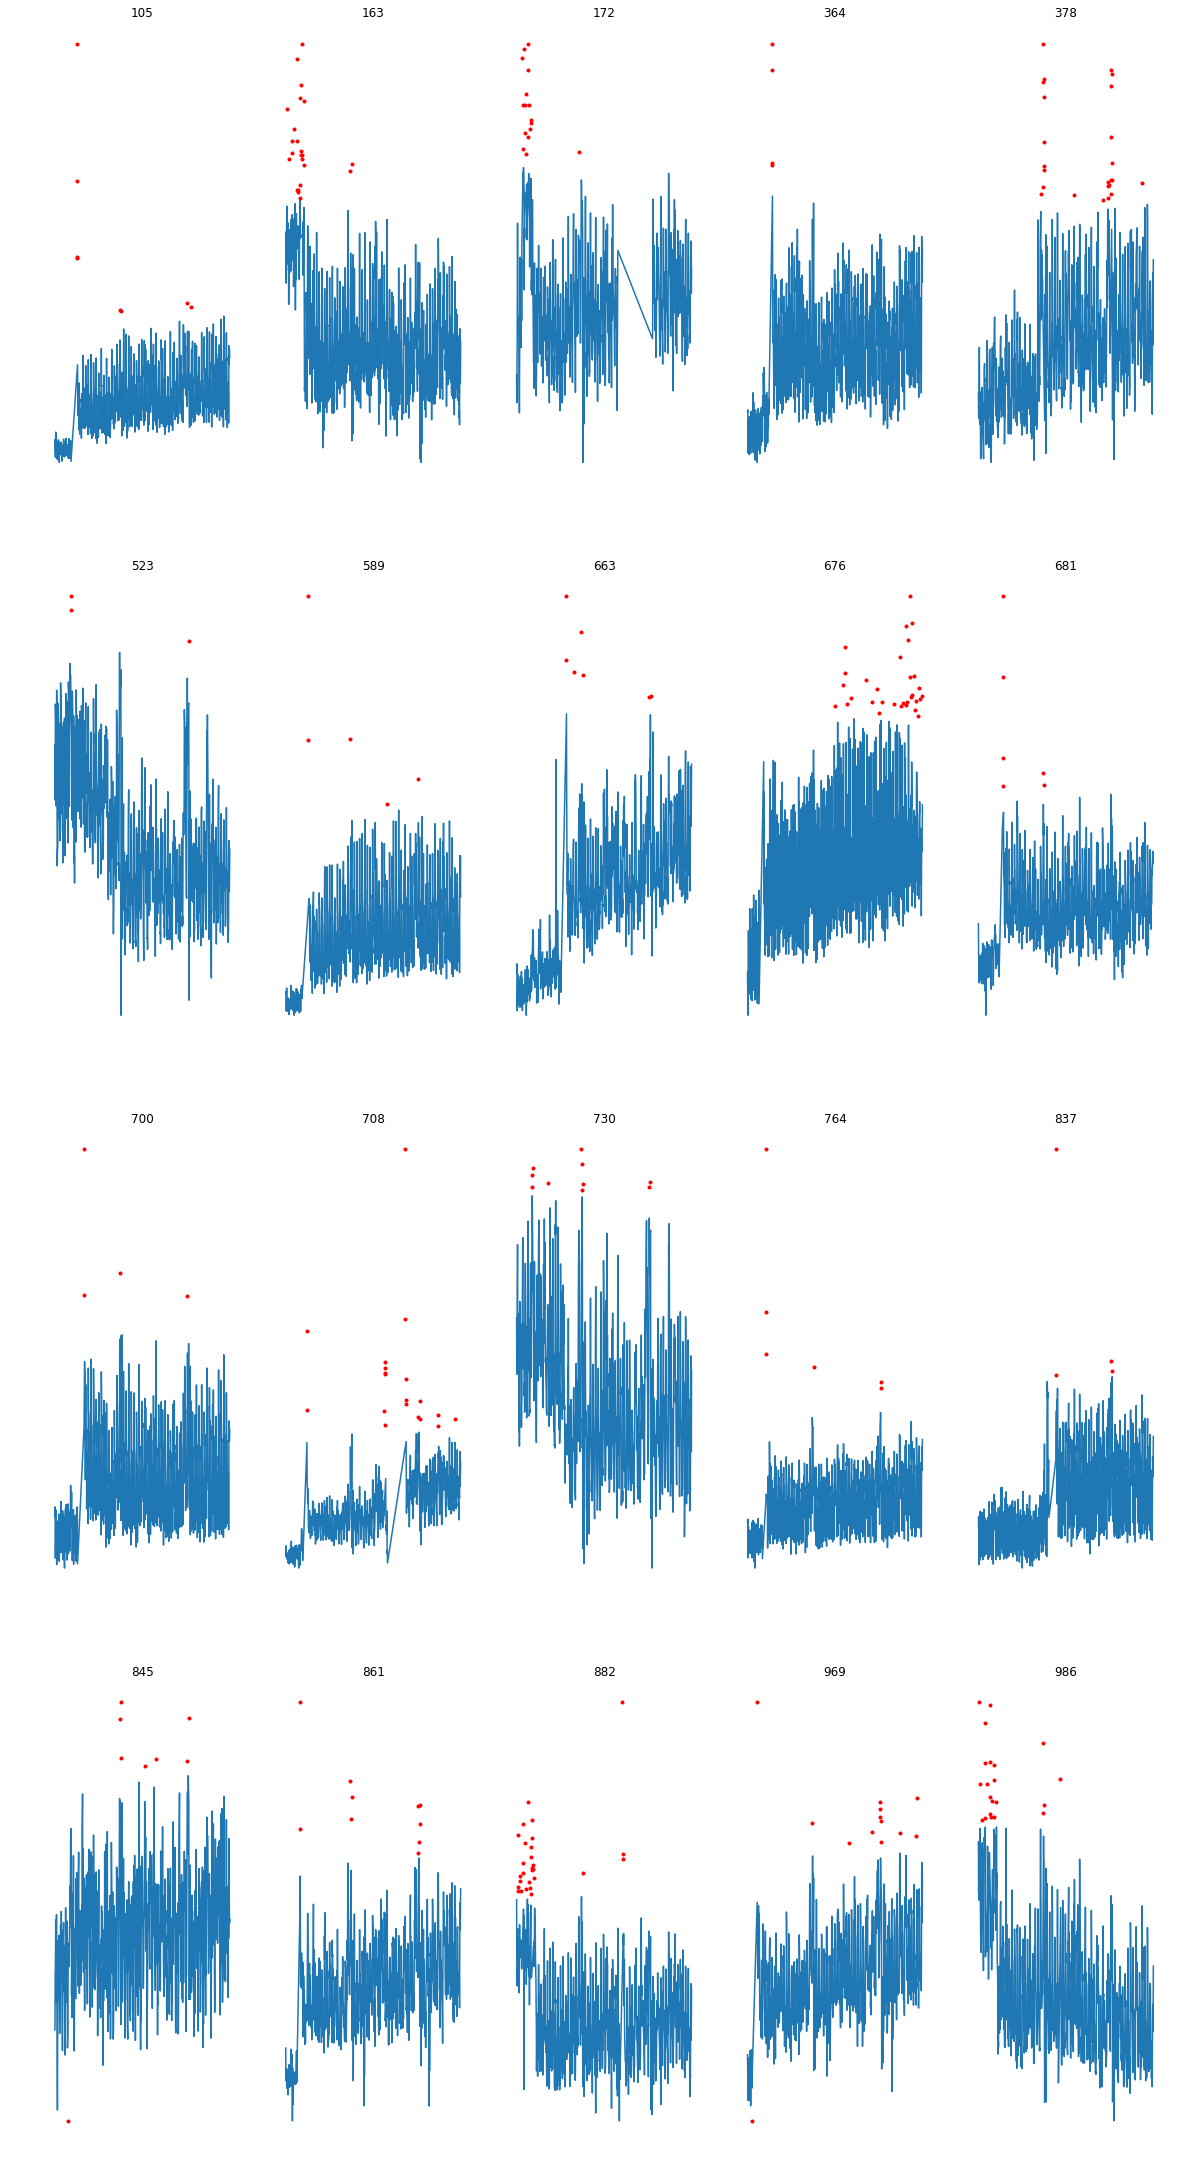

In [51]:
stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

plt.rcParams["figure.figsize"] = [20,len(stores_to_check)*5]

j = 1
for i in stores_to_check:
    
    # Normal sales
    X1 = sub_all_data.loc[(sub_all_data['Store'] == i) & (sub_all_data['Open'] == 1) & (sub_all_data['Outlier'] == False)]
    y1 = sub_all_data.loc[(sub_all_data['Store'] == i) & (sub_all_data['Open'] == 1) & (sub_all_data['Outlier'] == False)]['Sales']

    # Outliers
    X2 = sub_all_data.loc[(sub_all_data['Store'] == i) & (sub_all_data['Open'] == 1) & (sub_all_data['Outlier'] == True)]
    y2 = sub_all_data.loc[(sub_all_data['Store'] == i) & (sub_all_data['Open'] == 1) & (sub_all_data['Outlier'] == True)]['Sales']

    # Xt = df.loc[(df['Store'] == i)]
    
    plt.subplot(10,5,j)
    plt.plot(X1['Date'], y1, '-')
    plt.plot(X2['Date'], y2, 'r.')
    plt.title(i)
    plt.axis('off')
    j = j + 1

可以从上图中看出，红色点的确是异常值点

> Attention: sub_all_data新增特征：'Outlier'

**7.增加关于store的一些特征**

In [14]:
store_onehot = pd.get_dummies(store, columns=['StoreType'])
Assortment_mapping = {'a':1, 'b': 2, 'c':3}
store_onehot['Assortment_onehot'] = store_onehot['Assortment'].map(Assortment_mapping)

In [15]:
# 得到商铺历史销售总额，历史顾客数量，历史开业天数
store_sales = sub_all_data['Sales'].groupby(sub_all_data['Store']).sum()
store_customers = sub_all_data['Customers'].groupby(sub_all_data['Store']).sum()
store_opendays = sub_all_data['Open'].groupby(sub_all_data['Store']).count()

# 增加了店铺的三个特征
EachDay_store_sales = store_sales/store_opendays
EachDay_store_customers = store_customers/store_opendays
EachCustomer_cosume = EachDay_store_sales/EachDay_store_customers

In [16]:
store_onehot = pd.merge(store_onehot, EachDay_store_sales.reset_index(name='SalesPerDay'), how='left', on=['Store'])
store_onehot = pd.merge(store_onehot, EachDay_store_customers.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
store_onehot = pd.merge(store_onehot, EachCustomer_cosume.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])

In [17]:
store_features = ['Store', 'Assortment_onehot','StoreType_a','StoreType_b', 'StoreType_c', 'StoreType_d', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']
sub_all_data = pd.merge(sub_all_data, store_onehot[store_features], how='left', on=['Store'])

> store_onehot新增特征：'Assortment_onehot','StoreType_a','StoreType_b', 'StoreType_c', 'StoreType_d', 'SalesPerDay',
'CustomersPerDay', 'SalesPerCustomersPerDay'

> sub_all_data与store_onehot合并

**8.对Sales进行log处理**

In [18]:
sub_all_data['SalesLog'] = np.log(sub_all_data['Sales'] + 1)

### 保存数据

In [19]:
sub_all_data.to_pickle('sub_all_data_version2.pkl')

## 选择特征

In [20]:
features = sub_all_data.columns.values
features

array(['Customers', 'Date', 'DayOfWeek', 'Id', 'Insample', 'Open', 'Promo',
       'Sales', 'SchoolHoliday', 'Store', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'Day', 'Week',
       'Month', 'Year', 'DayOfYear', 'DateInt', 'Outlier',
       'Assortment_onehot', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'SalesPerDay', 'CustomersPerDay',
       'SalesPerCustomersPerDay', 'SalesLog'], dtype=object)

### 方案一

In [24]:
features_x = ['DayOfWeek', 'Open', 'Promo','SchoolHoliday', 'Store', 'StateHoliday_0','StateHoliday_a', 'StateHoliday_b',
              'StateHoliday_c', 'Day', 'Week','Month', 'Year', 'DayOfYear', 
              'Assortment_onehot', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'SalesPerDay',
              'CustomersPerDay','SalesPerCustomersPerDay']
features_y = ['SalesLog']

## 数据分割

### 随机分割

In [22]:
from sklearn.cross_validation import train_test_split

/Users/mingj/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
X_train, X_valid, Y_train, Y_valid = train_test_split(sub_all_data.loc[(sub_all_data['Insample'] == 1) & (sub_all_data['Open'] == 1) & (sub_all_data['Outlier'] == False)][features_x],
                                                    sub_all_data.loc[(sub_all_data['Insample'] == 1) & (sub_all_data['Open'] == 1) & (sub_all_data['Outlier'] == False)][features_y],
                                                    test_size=0.1, random_state=seed)

## 训练

### 随机分割

In [26]:
dtrain = xgb.DMatrix(X_train, Y_train)
dvalid = xgb.DMatrix(X_valid, Y_valid)

In [29]:
num_round = 10000
evallist = [(dtrain, 'train'), (dvalid, 'valid')]

In [81]:
param = {'bst:max_depth':12,
         'bst:eta':0.0095,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1, 
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}

plst = param.items()


In [82]:
bst = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=1, early_stopping_rounds=250)

[0]	train-rmse:5.78376	valid-rmse:5.78375	train-rmspe:0.996872	valid-rmspe:0.996874
Multiple eval metrics have been passed: 'valid-rmspe' will be used for early stopping.

Will train until valid-rmspe hasn't improved in 250 rounds.
[1]	train-rmse:4.05232	valid-rmse:4.05249	train-rmspe:0.981816	valid-rmspe:0.981825
[2]	train-rmse:2.84008	valid-rmse:2.8402	train-rmspe:0.939351	valid-rmspe:0.939344
[3]	train-rmse:1.99251	valid-rmse:1.99264	train-rmspe:0.859571	valid-rmspe:0.859409
[4]	train-rmse:1.40161	valid-rmse:1.4017	train-rmspe:0.747675	valid-rmspe:0.746923
[5]	train-rmse:0.98921	valid-rmse:0.989186	train-rmspe:0.621625	valid-rmspe:0.619458
[6]	train-rmse:0.704398	valid-rmse:0.704352	train-rmspe:0.500876	valid-rmspe:0.495722
[7]	train-rmse:0.508086	valid-rmse:0.507992	train-rmspe:0.398917	valid-rmspe:0.389349
[8]	train-rmse:0.375588	valid-rmse:0.375399	train-rmspe:0.32155	valid-rmspe:0.306231
[9]	train-rmse:0.288925	valid-rmse:0.28864	train-rmspe:0.271061	valid-rmspe:0.248571
[10]	tr

[94]	train-rmse:0.129925	valid-rmse:0.129854	train-rmspe:0.182151	valid-rmspe:0.140262
[95]	train-rmse:0.129514	valid-rmse:0.129488	train-rmspe:0.181655	valid-rmspe:0.139751
[96]	train-rmse:0.129261	valid-rmse:0.129272	train-rmspe:0.181423	valid-rmspe:0.139497
[97]	train-rmse:0.128948	valid-rmse:0.128984	train-rmspe:0.181132	valid-rmspe:0.13916
[98]	train-rmse:0.12889	valid-rmse:0.12893	train-rmspe:0.181121	valid-rmspe:0.13912
[99]	train-rmse:0.128617	valid-rmse:0.128665	train-rmspe:0.180891	valid-rmspe:0.138847
[100]	train-rmse:0.128508	valid-rmse:0.128566	train-rmspe:0.180784	valid-rmspe:0.138739
[101]	train-rmse:0.128392	valid-rmse:0.128463	train-rmspe:0.180697	valid-rmspe:0.138634
[102]	train-rmse:0.128049	valid-rmse:0.128136	train-rmspe:0.1804	valid-rmspe:0.138267
[103]	train-rmse:0.127819	valid-rmse:0.127897	train-rmspe:0.18023	valid-rmspe:0.138013
[104]	train-rmse:0.127752	valid-rmse:0.127841	train-rmspe:0.180176	valid-rmspe:0.137942
[105]	train-rmse:0.127689	valid-rmse:0.127787

[188]	train-rmse:0.114656	valid-rmse:0.11555	train-rmspe:0.158253	valid-rmspe:0.123441
[189]	train-rmse:0.114533	valid-rmse:0.115403	train-rmspe:0.158137	valid-rmspe:0.123262
[190]	train-rmse:0.114385	valid-rmse:0.115275	train-rmspe:0.157985	valid-rmspe:0.123098
[191]	train-rmse:0.114332	valid-rmse:0.11522	train-rmspe:0.157931	valid-rmspe:0.123026
[192]	train-rmse:0.114187	valid-rmse:0.115073	train-rmspe:0.157786	valid-rmspe:0.122835
[193]	train-rmse:0.114028	valid-rmse:0.114916	train-rmspe:0.157609	valid-rmspe:0.122683
[194]	train-rmse:0.113894	valid-rmse:0.114789	train-rmspe:0.157538	valid-rmspe:0.122573
[195]	train-rmse:0.113835	valid-rmse:0.114748	train-rmspe:0.157446	valid-rmspe:0.122519
[196]	train-rmse:0.113738	valid-rmse:0.114654	train-rmspe:0.157366	valid-rmspe:0.122423
[197]	train-rmse:0.113644	valid-rmse:0.11458	train-rmspe:0.157289	valid-rmspe:0.122362
[198]	train-rmse:0.113612	valid-rmse:0.114556	train-rmspe:0.15725	valid-rmspe:0.122337
[199]	train-rmse:0.113491	valid-rmse

[282]	train-rmse:0.10705	valid-rmse:0.108474	train-rmspe:0.151323	valid-rmspe:0.115715
[283]	train-rmse:0.107014	valid-rmse:0.108449	train-rmspe:0.151294	valid-rmspe:0.115705
[284]	train-rmse:0.106929	valid-rmse:0.108373	train-rmspe:0.151203	valid-rmspe:0.115633
[285]	train-rmse:0.106852	valid-rmse:0.108309	train-rmspe:0.151126	valid-rmspe:0.11556
[286]	train-rmse:0.106831	valid-rmse:0.108296	train-rmspe:0.151107	valid-rmspe:0.115557
[287]	train-rmse:0.106796	valid-rmse:0.108266	train-rmspe:0.151076	valid-rmspe:0.115517
[288]	train-rmse:0.106667	valid-rmse:0.10814	train-rmspe:0.150974	valid-rmspe:0.115375
[289]	train-rmse:0.106634	valid-rmse:0.108113	train-rmspe:0.150937	valid-rmspe:0.115343
[290]	train-rmse:0.106597	valid-rmse:0.10808	train-rmspe:0.150896	valid-rmspe:0.115309
[291]	train-rmse:0.106568	valid-rmse:0.108061	train-rmspe:0.150824	valid-rmspe:0.115282
[292]	train-rmse:0.106537	valid-rmse:0.108037	train-rmspe:0.150804	valid-rmspe:0.115276
[293]	train-rmse:0.106416	valid-rmse

[376]	train-rmse:0.102064	valid-rmse:0.1042	train-rmspe:0.147788	valid-rmspe:0.111176
[377]	train-rmse:0.102034	valid-rmse:0.104173	train-rmspe:0.147778	valid-rmspe:0.111157
[378]	train-rmse:0.101973	valid-rmse:0.104115	train-rmspe:0.147728	valid-rmspe:0.111087
[379]	train-rmse:0.101909	valid-rmse:0.104049	train-rmspe:0.147685	valid-rmspe:0.111025
[380]	train-rmse:0.101881	valid-rmse:0.104025	train-rmspe:0.147641	valid-rmspe:0.111012
[381]	train-rmse:0.101864	valid-rmse:0.104019	train-rmspe:0.147629	valid-rmspe:0.111005
[382]	train-rmse:0.10177	valid-rmse:0.103935	train-rmspe:0.147544	valid-rmspe:0.110917
[383]	train-rmse:0.101744	valid-rmse:0.103914	train-rmspe:0.147518	valid-rmspe:0.110891
[384]	train-rmse:0.101722	valid-rmse:0.103899	train-rmspe:0.147494	valid-rmspe:0.110881
[385]	train-rmse:0.101705	valid-rmse:0.103888	train-rmspe:0.147475	valid-rmspe:0.110862
[386]	train-rmse:0.101684	valid-rmse:0.10388	train-rmspe:0.147449	valid-rmspe:0.110848
[387]	train-rmse:0.101625	valid-rmse

[470]	train-rmse:0.09835	valid-rmse:0.100989	train-rmspe:0.137908	valid-rmspe:0.107844
[471]	train-rmse:0.098302	valid-rmse:0.100948	train-rmspe:0.137882	valid-rmspe:0.107798
[472]	train-rmse:0.098287	valid-rmse:0.100934	train-rmspe:0.137873	valid-rmspe:0.107785
[473]	train-rmse:0.098251	valid-rmse:0.100906	train-rmspe:0.137849	valid-rmspe:0.107762
[474]	train-rmse:0.098223	valid-rmse:0.100887	train-rmspe:0.137816	valid-rmspe:0.107743
[475]	train-rmse:0.098155	valid-rmse:0.100828	train-rmspe:0.137738	valid-rmspe:0.107687
[476]	train-rmse:0.098138	valid-rmse:0.100814	train-rmspe:0.13773	valid-rmspe:0.10767
[477]	train-rmse:0.098039	valid-rmse:0.10071	train-rmspe:0.137649	valid-rmspe:0.107582
[478]	train-rmse:0.098019	valid-rmse:0.10069	train-rmspe:0.137653	valid-rmspe:0.107563
[479]	train-rmse:0.097958	valid-rmse:0.100637	train-rmspe:0.137605	valid-rmspe:0.107469
[480]	train-rmse:0.097919	valid-rmse:0.100602	train-rmspe:0.137553	valid-rmspe:0.107435
[481]	train-rmse:0.097881	valid-rmse:

[564]	train-rmse:0.095194	valid-rmse:0.098275	train-rmspe:0.13552	valid-rmspe:0.10497
[565]	train-rmse:0.095167	valid-rmse:0.098255	train-rmspe:0.135509	valid-rmspe:0.104956
[566]	train-rmse:0.095154	valid-rmse:0.098247	train-rmspe:0.135514	valid-rmspe:0.104947
[567]	train-rmse:0.095121	valid-rmse:0.098228	train-rmspe:0.135498	valid-rmspe:0.10493
[568]	train-rmse:0.09511	valid-rmse:0.098226	train-rmspe:0.135483	valid-rmspe:0.104927
[569]	train-rmse:0.095075	valid-rmse:0.098198	train-rmspe:0.135431	valid-rmspe:0.104898
[570]	train-rmse:0.095056	valid-rmse:0.098183	train-rmspe:0.135433	valid-rmspe:0.104881
[571]	train-rmse:0.095036	valid-rmse:0.098169	train-rmspe:0.135399	valid-rmspe:0.104857
[572]	train-rmse:0.095018	valid-rmse:0.098157	train-rmspe:0.135381	valid-rmspe:0.104847
[573]	train-rmse:0.094993	valid-rmse:0.098138	train-rmspe:0.135376	valid-rmspe:0.10483
[574]	train-rmse:0.094958	valid-rmse:0.098112	train-rmspe:0.13534	valid-rmspe:0.104814
[575]	train-rmse:0.094926	valid-rmse:0

[658]	train-rmse:0.093024	valid-rmse:0.096624	train-rmspe:0.132838	valid-rmspe:0.103328
[659]	train-rmse:0.092999	valid-rmse:0.096604	train-rmspe:0.132827	valid-rmspe:0.103312
[660]	train-rmse:0.092972	valid-rmse:0.096583	train-rmspe:0.132877	valid-rmspe:0.103293
[661]	train-rmse:0.092956	valid-rmse:0.096568	train-rmspe:0.132863	valid-rmspe:0.103278
[662]	train-rmse:0.092907	valid-rmse:0.096529	train-rmspe:0.132839	valid-rmspe:0.103255
[663]	train-rmse:0.092883	valid-rmse:0.096512	train-rmspe:0.132818	valid-rmspe:0.103246
[664]	train-rmse:0.092868	valid-rmse:0.096498	train-rmspe:0.132807	valid-rmspe:0.103233
[665]	train-rmse:0.092854	valid-rmse:0.096489	train-rmspe:0.132794	valid-rmspe:0.103229
[666]	train-rmse:0.092836	valid-rmse:0.096481	train-rmspe:0.132785	valid-rmspe:0.103225
[667]	train-rmse:0.092801	valid-rmse:0.096453	train-rmspe:0.132742	valid-rmspe:0.103194
[668]	train-rmse:0.092796	valid-rmse:0.096449	train-rmspe:0.132736	valid-rmspe:0.103186
[669]	train-rmse:0.092783	valid-

[752]	train-rmse:0.091126	valid-rmse:0.095206	train-rmspe:0.131863	valid-rmspe:0.101998
[753]	train-rmse:0.09111	valid-rmse:0.095197	train-rmspe:0.131816	valid-rmspe:0.101991
[754]	train-rmse:0.091087	valid-rmse:0.095174	train-rmspe:0.131831	valid-rmspe:0.101967
[755]	train-rmse:0.091073	valid-rmse:0.095161	train-rmspe:0.13182	valid-rmspe:0.101955
[756]	train-rmse:0.091057	valid-rmse:0.095153	train-rmspe:0.131806	valid-rmspe:0.101937
[757]	train-rmse:0.091026	valid-rmse:0.095126	train-rmspe:0.131805	valid-rmspe:0.101921
[758]	train-rmse:0.091016	valid-rmse:0.095121	train-rmspe:0.1318	valid-rmspe:0.101916
[759]	train-rmse:0.090997	valid-rmse:0.095112	train-rmspe:0.13178	valid-rmspe:0.101908
[760]	train-rmse:0.090975	valid-rmse:0.095099	train-rmspe:0.131758	valid-rmspe:0.101898
[761]	train-rmse:0.090957	valid-rmse:0.095086	train-rmspe:0.131916	valid-rmspe:0.101885
[762]	train-rmse:0.09093	valid-rmse:0.095063	train-rmspe:0.131889	valid-rmspe:0.101862
[763]	train-rmse:0.090905	valid-rmse:0

[846]	train-rmse:0.089477	valid-rmse:0.094061	train-rmspe:0.127626	valid-rmspe:0.100761
[847]	train-rmse:0.089458	valid-rmse:0.094044	train-rmspe:0.127611	valid-rmspe:0.100742
[848]	train-rmse:0.089446	valid-rmse:0.09405	train-rmspe:0.127552	valid-rmspe:0.100751
[849]	train-rmse:0.08943	valid-rmse:0.094032	train-rmspe:0.12754	valid-rmspe:0.100728
[850]	train-rmse:0.089419	valid-rmse:0.094025	train-rmspe:0.12753	valid-rmspe:0.100718
[851]	train-rmse:0.089407	valid-rmse:0.094016	train-rmspe:0.127515	valid-rmspe:0.100713
[852]	train-rmse:0.089394	valid-rmse:0.094008	train-rmspe:0.127505	valid-rmspe:0.100688
[853]	train-rmse:0.08937	valid-rmse:0.09399	train-rmspe:0.127485	valid-rmspe:0.100663
[854]	train-rmse:0.089332	valid-rmse:0.093965	train-rmspe:0.127447	valid-rmspe:0.100633
[855]	train-rmse:0.089317	valid-rmse:0.093954	train-rmspe:0.127356	valid-rmspe:0.100619
[856]	train-rmse:0.0893	valid-rmse:0.093946	train-rmspe:0.127341	valid-rmspe:0.100622
[857]	train-rmse:0.089287	valid-rmse:0.0

[940]	train-rmse:0.088015	valid-rmse:0.093048	train-rmspe:0.126282	valid-rmspe:0.099651
[941]	train-rmse:0.088	valid-rmse:0.093035	train-rmspe:0.126267	valid-rmspe:0.099639
[942]	train-rmse:0.087982	valid-rmse:0.093018	train-rmspe:0.126255	valid-rmspe:0.099625
[943]	train-rmse:0.087972	valid-rmse:0.093011	train-rmspe:0.126252	valid-rmspe:0.099622
[944]	train-rmse:0.08796	valid-rmse:0.093005	train-rmspe:0.126238	valid-rmspe:0.099611
[945]	train-rmse:0.087949	valid-rmse:0.092999	train-rmspe:0.126235	valid-rmspe:0.099601
[946]	train-rmse:0.087937	valid-rmse:0.092996	train-rmspe:0.126238	valid-rmspe:0.099599
[947]	train-rmse:0.087923	valid-rmse:0.092985	train-rmspe:0.126222	valid-rmspe:0.099579
[948]	train-rmse:0.0879	valid-rmse:0.092965	train-rmspe:0.126216	valid-rmspe:0.099559
[949]	train-rmse:0.087885	valid-rmse:0.092955	train-rmspe:0.126205	valid-rmspe:0.09955
[950]	train-rmse:0.087844	valid-rmse:0.092927	train-rmspe:0.126177	valid-rmspe:0.099521
[951]	train-rmse:0.087833	valid-rmse:0.

[1034]	train-rmse:0.086819	valid-rmse:0.092273	train-rmspe:0.123713	valid-rmspe:0.098867
[1035]	train-rmse:0.086812	valid-rmse:0.09227	train-rmspe:0.123694	valid-rmspe:0.098857
[1036]	train-rmse:0.086794	valid-rmse:0.092247	train-rmspe:0.123686	valid-rmspe:0.098827
[1037]	train-rmse:0.086786	valid-rmse:0.092242	train-rmspe:0.123689	valid-rmspe:0.098826
[1038]	train-rmse:0.086767	valid-rmse:0.092229	train-rmspe:0.123671	valid-rmspe:0.098813
[1039]	train-rmse:0.086752	valid-rmse:0.09222	train-rmspe:0.123655	valid-rmspe:0.098804
[1040]	train-rmse:0.086744	valid-rmse:0.092215	train-rmspe:0.123649	valid-rmspe:0.098801
[1041]	train-rmse:0.086734	valid-rmse:0.092206	train-rmspe:0.123652	valid-rmspe:0.098789
[1042]	train-rmse:0.086727	valid-rmse:0.092201	train-rmspe:0.123649	valid-rmspe:0.09879
[1043]	train-rmse:0.086707	valid-rmse:0.092204	train-rmspe:0.1235	valid-rmspe:0.098796
[1044]	train-rmse:0.0867	valid-rmse:0.092198	train-rmspe:0.123487	valid-rmspe:0.098789
[1045]	train-rmse:0.086692	v

[1127]	train-rmse:0.085818	valid-rmse:0.09165	train-rmspe:0.122612	valid-rmspe:0.098079
[1128]	train-rmse:0.085801	valid-rmse:0.091636	train-rmspe:0.122596	valid-rmspe:0.098072
[1129]	train-rmse:0.085763	valid-rmse:0.091614	train-rmspe:0.122558	valid-rmspe:0.098043
[1130]	train-rmse:0.08575	valid-rmse:0.091603	train-rmspe:0.122865	valid-rmspe:0.098035
[1131]	train-rmse:0.085741	valid-rmse:0.091595	train-rmspe:0.122859	valid-rmspe:0.098023
[1132]	train-rmse:0.085731	valid-rmse:0.09159	train-rmspe:0.122848	valid-rmspe:0.098023
[1133]	train-rmse:0.085722	valid-rmse:0.091589	train-rmspe:0.122835	valid-rmspe:0.098013
[1134]	train-rmse:0.085711	valid-rmse:0.091581	train-rmspe:0.122823	valid-rmspe:0.098004
[1135]	train-rmse:0.085704	valid-rmse:0.091579	train-rmspe:0.122816	valid-rmspe:0.098002
[1136]	train-rmse:0.085688	valid-rmse:0.091569	train-rmspe:0.122799	valid-rmspe:0.097988
[1137]	train-rmse:0.085676	valid-rmse:0.091563	train-rmspe:0.122786	valid-rmspe:0.097975
[1138]	train-rmse:0.0856

[1220]	train-rmse:0.084895	valid-rmse:0.091079	train-rmspe:0.124637	valid-rmspe:0.097399
[1221]	train-rmse:0.084888	valid-rmse:0.091076	train-rmspe:0.124627	valid-rmspe:0.097393
[1222]	train-rmse:0.084882	valid-rmse:0.091073	train-rmspe:0.124621	valid-rmspe:0.09739
[1223]	train-rmse:0.084871	valid-rmse:0.091069	train-rmspe:0.124595	valid-rmspe:0.097398
[1224]	train-rmse:0.084865	valid-rmse:0.091069	train-rmspe:0.124617	valid-rmspe:0.097401
[1225]	train-rmse:0.08486	valid-rmse:0.091067	train-rmspe:0.124613	valid-rmspe:0.097399
[1226]	train-rmse:0.084846	valid-rmse:0.091056	train-rmspe:0.124598	valid-rmspe:0.097389
[1227]	train-rmse:0.08483	valid-rmse:0.091045	train-rmspe:0.124571	valid-rmspe:0.097383
[1228]	train-rmse:0.084819	valid-rmse:0.091039	train-rmspe:0.12456	valid-rmspe:0.097376
[1229]	train-rmse:0.084798	valid-rmse:0.091029	train-rmspe:0.124553	valid-rmspe:0.097365
[1230]	train-rmse:0.084795	valid-rmse:0.091026	train-rmspe:0.124561	valid-rmspe:0.097363
[1231]	train-rmse:0.08477

[1313]	train-rmse:0.084022	valid-rmse:0.090625	train-rmspe:0.11474	valid-rmspe:0.097008
[1314]	train-rmse:0.084015	valid-rmse:0.090625	train-rmspe:0.114731	valid-rmspe:0.097016
[1315]	train-rmse:0.084002	valid-rmse:0.090617	train-rmspe:0.114681	valid-rmspe:0.097009
[1316]	train-rmse:0.083995	valid-rmse:0.090613	train-rmspe:0.114668	valid-rmspe:0.097003
[1317]	train-rmse:0.083989	valid-rmse:0.09061	train-rmspe:0.114661	valid-rmspe:0.097001
[1318]	train-rmse:0.083984	valid-rmse:0.09061	train-rmspe:0.114661	valid-rmspe:0.097004
[1319]	train-rmse:0.083969	valid-rmse:0.09062	train-rmspe:0.114627	valid-rmspe:0.097032
[1320]	train-rmse:0.083951	valid-rmse:0.090612	train-rmspe:0.114604	valid-rmspe:0.097016
[1321]	train-rmse:0.083939	valid-rmse:0.090606	train-rmspe:0.114596	valid-rmspe:0.097011
[1322]	train-rmse:0.083929	valid-rmse:0.090598	train-rmspe:0.114592	valid-rmspe:0.097006
[1323]	train-rmse:0.083917	valid-rmse:0.090589	train-rmspe:0.114589	valid-rmspe:0.097002
[1324]	train-rmse:0.08390

[1406]	train-rmse:0.083248	valid-rmse:0.090281	train-rmspe:0.110403	valid-rmspe:0.096675
[1407]	train-rmse:0.083238	valid-rmse:0.090269	train-rmspe:0.110391	valid-rmspe:0.096661
[1408]	train-rmse:0.083229	valid-rmse:0.090263	train-rmspe:0.110386	valid-rmspe:0.096655
[1409]	train-rmse:0.083225	valid-rmse:0.090263	train-rmspe:0.110299	valid-rmspe:0.09665
[1410]	train-rmse:0.083212	valid-rmse:0.09025	train-rmspe:0.11029	valid-rmspe:0.096638
[1411]	train-rmse:0.083207	valid-rmse:0.09025	train-rmspe:0.110284	valid-rmspe:0.096634
[1412]	train-rmse:0.083193	valid-rmse:0.090243	train-rmspe:0.110272	valid-rmspe:0.096635
[1413]	train-rmse:0.083179	valid-rmse:0.090235	train-rmspe:0.110193	valid-rmspe:0.096625
[1414]	train-rmse:0.083172	valid-rmse:0.090231	train-rmspe:0.110197	valid-rmspe:0.096621
[1415]	train-rmse:0.083159	valid-rmse:0.090218	train-rmspe:0.110183	valid-rmspe:0.096605
[1416]	train-rmse:0.083153	valid-rmse:0.090214	train-rmspe:0.110176	valid-rmspe:0.096599
[1417]	train-rmse:0.08314

[1499]	train-rmse:0.082507	valid-rmse:0.08986	train-rmspe:0.10876	valid-rmspe:0.096272
[1500]	train-rmse:0.0825	valid-rmse:0.089862	train-rmspe:0.108755	valid-rmspe:0.096272
[1501]	train-rmse:0.082488	valid-rmse:0.089856	train-rmspe:0.108747	valid-rmspe:0.096268
[1502]	train-rmse:0.082477	valid-rmse:0.08985	train-rmspe:0.108748	valid-rmspe:0.096265
[1503]	train-rmse:0.082469	valid-rmse:0.089841	train-rmspe:0.108753	valid-rmspe:0.096256
[1504]	train-rmse:0.082461	valid-rmse:0.089837	train-rmspe:0.108732	valid-rmspe:0.096248
[1505]	train-rmse:0.082457	valid-rmse:0.089836	train-rmspe:0.108731	valid-rmspe:0.096251
[1506]	train-rmse:0.08245	valid-rmse:0.089832	train-rmspe:0.108729	valid-rmspe:0.096249
[1507]	train-rmse:0.082447	valid-rmse:0.089832	train-rmspe:0.108741	valid-rmspe:0.096265
[1508]	train-rmse:0.082439	valid-rmse:0.089826	train-rmspe:0.108747	valid-rmspe:0.096262
[1509]	train-rmse:0.082434	valid-rmse:0.089827	train-rmspe:0.108743	valid-rmspe:0.096263
[1510]	train-rmse:0.08243	v

[1592]	train-rmse:0.081825	valid-rmse:0.089541	train-rmspe:0.108066	valid-rmspe:0.095993
[1593]	train-rmse:0.081817	valid-rmse:0.089538	train-rmspe:0.108055	valid-rmspe:0.096003
[1594]	train-rmse:0.081812	valid-rmse:0.089536	train-rmspe:0.108052	valid-rmspe:0.09601
[1595]	train-rmse:0.081806	valid-rmse:0.089536	train-rmspe:0.108051	valid-rmspe:0.096029
[1596]	train-rmse:0.0818	valid-rmse:0.08954	train-rmspe:0.108046	valid-rmspe:0.096032
[1597]	train-rmse:0.081792	valid-rmse:0.089535	train-rmspe:0.108027	valid-rmspe:0.096024
[1598]	train-rmse:0.081783	valid-rmse:0.089534	train-rmspe:0.108	valid-rmspe:0.096026
[1599]	train-rmse:0.081765	valid-rmse:0.089523	train-rmspe:0.107987	valid-rmspe:0.096014
[1600]	train-rmse:0.081758	valid-rmse:0.089521	train-rmspe:0.107979	valid-rmspe:0.09601
[1601]	train-rmse:0.081743	valid-rmse:0.089511	train-rmspe:0.107965	valid-rmspe:0.096006
[1602]	train-rmse:0.081738	valid-rmse:0.089515	train-rmspe:0.108061	valid-rmspe:0.09601
[1603]	train-rmse:0.081731	val

[1685]	train-rmse:0.081206	valid-rmse:0.089237	train-rmspe:0.107594	valid-rmspe:0.095717
[1686]	train-rmse:0.081202	valid-rmse:0.089236	train-rmspe:0.107595	valid-rmspe:0.095713
[1687]	train-rmse:0.081196	valid-rmse:0.089237	train-rmspe:0.107593	valid-rmspe:0.095718
[1688]	train-rmse:0.081181	valid-rmse:0.089225	train-rmspe:0.107582	valid-rmspe:0.095709
[1689]	train-rmse:0.081179	valid-rmse:0.089227	train-rmspe:0.107582	valid-rmspe:0.095711
[1690]	train-rmse:0.081173	valid-rmse:0.089222	train-rmspe:0.107576	valid-rmspe:0.095706
[1691]	train-rmse:0.081167	valid-rmse:0.089222	train-rmspe:0.107575	valid-rmspe:0.095707
[1692]	train-rmse:0.08116	valid-rmse:0.089219	train-rmspe:0.107568	valid-rmspe:0.0957
[1693]	train-rmse:0.081155	valid-rmse:0.089215	train-rmspe:0.107561	valid-rmspe:0.095695
[1694]	train-rmse:0.08115	valid-rmse:0.089211	train-rmspe:0.107535	valid-rmspe:0.095685
[1695]	train-rmse:0.081146	valid-rmse:0.089212	train-rmspe:0.107528	valid-rmspe:0.095683
[1696]	train-rmse:0.08114

[1778]	train-rmse:0.080638	valid-rmse:0.089004	train-rmspe:0.105455	valid-rmspe:0.095487
[1779]	train-rmse:0.080635	valid-rmse:0.089004	train-rmspe:0.10548	valid-rmspe:0.095489
[1780]	train-rmse:0.080629	valid-rmse:0.089004	train-rmspe:0.105471	valid-rmspe:0.095486
[1781]	train-rmse:0.080624	valid-rmse:0.089	train-rmspe:0.105467	valid-rmspe:0.095481
[1782]	train-rmse:0.080618	valid-rmse:0.088997	train-rmspe:0.105469	valid-rmspe:0.095476
[1783]	train-rmse:0.080614	valid-rmse:0.088993	train-rmspe:0.105463	valid-rmspe:0.095473
[1784]	train-rmse:0.080606	valid-rmse:0.088987	train-rmspe:0.105458	valid-rmspe:0.095469
[1785]	train-rmse:0.080594	valid-rmse:0.088983	train-rmspe:0.10545	valid-rmspe:0.095473
[1786]	train-rmse:0.08059	valid-rmse:0.088983	train-rmspe:0.105445	valid-rmspe:0.095474
[1787]	train-rmse:0.080583	valid-rmse:0.088979	train-rmspe:0.105442	valid-rmspe:0.095469
[1788]	train-rmse:0.080576	valid-rmse:0.088982	train-rmspe:0.105438	valid-rmspe:0.095476
[1789]	train-rmse:0.08057	v

[1871]	train-rmse:0.080069	valid-rmse:0.088812	train-rmspe:0.092878	valid-rmspe:0.095265
[1872]	train-rmse:0.080063	valid-rmse:0.088807	train-rmspe:0.092869	valid-rmspe:0.095261
[1873]	train-rmse:0.080059	valid-rmse:0.088801	train-rmspe:0.092861	valid-rmspe:0.095246
[1874]	train-rmse:0.080052	valid-rmse:0.088801	train-rmspe:0.092858	valid-rmspe:0.095248
[1875]	train-rmse:0.08005	valid-rmse:0.088799	train-rmspe:0.092856	valid-rmspe:0.095245
[1876]	train-rmse:0.080043	valid-rmse:0.088795	train-rmspe:0.092854	valid-rmspe:0.095246
[1877]	train-rmse:0.080038	valid-rmse:0.088792	train-rmspe:0.092848	valid-rmspe:0.09524
[1878]	train-rmse:0.080024	valid-rmse:0.088777	train-rmspe:0.092833	valid-rmspe:0.095225
[1879]	train-rmse:0.080022	valid-rmse:0.088778	train-rmspe:0.092829	valid-rmspe:0.095225
[1880]	train-rmse:0.080017	valid-rmse:0.088779	train-rmspe:0.092828	valid-rmspe:0.095226
[1881]	train-rmse:0.080014	valid-rmse:0.088784	train-rmspe:0.092819	valid-rmspe:0.095228
[1882]	train-rmse:0.080

[1964]	train-rmse:0.079508	valid-rmse:0.088561	train-rmspe:0.092279	valid-rmspe:0.094875
[1965]	train-rmse:0.079503	valid-rmse:0.088561	train-rmspe:0.092274	valid-rmspe:0.094871
[1966]	train-rmse:0.079495	valid-rmse:0.088555	train-rmspe:0.092269	valid-rmspe:0.094867
[1967]	train-rmse:0.079489	valid-rmse:0.088552	train-rmspe:0.092266	valid-rmspe:0.094868
[1968]	train-rmse:0.079486	valid-rmse:0.088551	train-rmspe:0.092261	valid-rmspe:0.094865
[1969]	train-rmse:0.079483	valid-rmse:0.088549	train-rmspe:0.092259	valid-rmspe:0.094867
[1970]	train-rmse:0.079475	valid-rmse:0.088547	train-rmspe:0.092245	valid-rmspe:0.094861
[1971]	train-rmse:0.079466	valid-rmse:0.088549	train-rmspe:0.092233	valid-rmspe:0.09488
[1972]	train-rmse:0.079462	valid-rmse:0.088547	train-rmspe:0.092229	valid-rmspe:0.094877
[1973]	train-rmse:0.079452	valid-rmse:0.088537	train-rmspe:0.092221	valid-rmspe:0.094865
[1974]	train-rmse:0.079446	valid-rmse:0.088536	train-rmspe:0.092222	valid-rmspe:0.094869
[1975]	train-rmse:0.07

[2057]	train-rmse:0.079001	valid-rmse:0.088366	train-rmspe:0.091435	valid-rmspe:0.094678
[2058]	train-rmse:0.078994	valid-rmse:0.088368	train-rmspe:0.091427	valid-rmspe:0.094675
[2059]	train-rmse:0.07899	valid-rmse:0.088367	train-rmspe:0.091423	valid-rmspe:0.094678
[2060]	train-rmse:0.078981	valid-rmse:0.08836	train-rmspe:0.091415	valid-rmspe:0.094672
[2061]	train-rmse:0.078978	valid-rmse:0.088362	train-rmspe:0.09141	valid-rmspe:0.094674
[2062]	train-rmse:0.078967	valid-rmse:0.088355	train-rmspe:0.091401	valid-rmspe:0.094667
[2063]	train-rmse:0.078959	valid-rmse:0.08836	train-rmspe:0.091392	valid-rmspe:0.094698
[2064]	train-rmse:0.078954	valid-rmse:0.088362	train-rmspe:0.091388	valid-rmspe:0.094703
[2065]	train-rmse:0.078945	valid-rmse:0.088361	train-rmspe:0.091384	valid-rmspe:0.094724
[2066]	train-rmse:0.078937	valid-rmse:0.088354	train-rmspe:0.091375	valid-rmspe:0.094719
[2067]	train-rmse:0.078926	valid-rmse:0.088348	train-rmspe:0.091365	valid-rmspe:0.094715
[2068]	train-rmse:0.07892

[2150]	train-rmse:0.078494	valid-rmse:0.088203	train-rmspe:0.090947	valid-rmspe:0.094609
[2151]	train-rmse:0.078491	valid-rmse:0.088202	train-rmspe:0.090942	valid-rmspe:0.094606
[2152]	train-rmse:0.078483	valid-rmse:0.088196	train-rmspe:0.090934	valid-rmspe:0.094601
[2153]	train-rmse:0.078472	valid-rmse:0.08819	train-rmspe:0.090926	valid-rmspe:0.0946
[2154]	train-rmse:0.07847	valid-rmse:0.088189	train-rmspe:0.090922	valid-rmspe:0.094599
[2155]	train-rmse:0.078466	valid-rmse:0.088187	train-rmspe:0.090919	valid-rmspe:0.094599
[2156]	train-rmse:0.078462	valid-rmse:0.088187	train-rmspe:0.090912	valid-rmspe:0.094595
[2157]	train-rmse:0.078454	valid-rmse:0.088181	train-rmspe:0.090902	valid-rmspe:0.094586
[2158]	train-rmse:0.07845	valid-rmse:0.088179	train-rmspe:0.0909	valid-rmspe:0.094583
[2159]	train-rmse:0.078445	valid-rmse:0.088178	train-rmspe:0.090899	valid-rmspe:0.094587
[2160]	train-rmse:0.078439	valid-rmse:0.088177	train-rmspe:0.090893	valid-rmspe:0.094588
[2161]	train-rmse:0.078428	v

[2243]	train-rmse:0.077998	valid-rmse:0.088	train-rmspe:0.090245	valid-rmspe:0.094376
[2244]	train-rmse:0.077991	valid-rmse:0.087995	train-rmspe:0.09023	valid-rmspe:0.09437
[2245]	train-rmse:0.077986	valid-rmse:0.087993	train-rmspe:0.090226	valid-rmspe:0.09437
[2246]	train-rmse:0.077977	valid-rmse:0.087989	train-rmspe:0.090221	valid-rmspe:0.094369
[2247]	train-rmse:0.077973	valid-rmse:0.087987	train-rmspe:0.090217	valid-rmspe:0.094369
[2248]	train-rmse:0.077966	valid-rmse:0.087981	train-rmspe:0.090207	valid-rmspe:0.094361
[2249]	train-rmse:0.077963	valid-rmse:0.087983	train-rmspe:0.090204	valid-rmspe:0.094363
[2250]	train-rmse:0.07796	valid-rmse:0.087979	train-rmspe:0.0902	valid-rmspe:0.094356
[2251]	train-rmse:0.077956	valid-rmse:0.087976	train-rmspe:0.090196	valid-rmspe:0.094351
[2252]	train-rmse:0.077949	valid-rmse:0.087976	train-rmspe:0.09019	valid-rmspe:0.094353
[2253]	train-rmse:0.077943	valid-rmse:0.08797	train-rmspe:0.090183	valid-rmspe:0.09435
[2254]	train-rmse:0.077938	valid-

[2336]	train-rmse:0.077583	valid-rmse:0.087884	train-rmspe:0.089661	valid-rmspe:0.094277
[2337]	train-rmse:0.07758	valid-rmse:0.087883	train-rmspe:0.089658	valid-rmspe:0.094279
[2338]	train-rmse:0.077576	valid-rmse:0.087884	train-rmspe:0.089653	valid-rmspe:0.094277
[2339]	train-rmse:0.077572	valid-rmse:0.087885	train-rmspe:0.089651	valid-rmspe:0.09428
[2340]	train-rmse:0.077569	valid-rmse:0.087883	train-rmspe:0.089648	valid-rmspe:0.094276
[2341]	train-rmse:0.077564	valid-rmse:0.087882	train-rmspe:0.089641	valid-rmspe:0.094274
[2342]	train-rmse:0.077561	valid-rmse:0.087882	train-rmspe:0.089632	valid-rmspe:0.09427
[2343]	train-rmse:0.077557	valid-rmse:0.087881	train-rmspe:0.089628	valid-rmspe:0.094269
[2344]	train-rmse:0.077554	valid-rmse:0.087876	train-rmspe:0.089624	valid-rmspe:0.094258
[2345]	train-rmse:0.077549	valid-rmse:0.08787	train-rmspe:0.089601	valid-rmspe:0.094249
[2346]	train-rmse:0.077541	valid-rmse:0.087862	train-rmspe:0.089597	valid-rmspe:0.094244
[2347]	train-rmse:0.07753

[2429]	train-rmse:0.077136	valid-rmse:0.087733	train-rmspe:0.085347	valid-rmspe:0.094156
[2430]	train-rmse:0.077129	valid-rmse:0.087727	train-rmspe:0.085342	valid-rmspe:0.094153
[2431]	train-rmse:0.077127	valid-rmse:0.087724	train-rmspe:0.085336	valid-rmspe:0.094149
[2432]	train-rmse:0.077122	valid-rmse:0.087726	train-rmspe:0.085326	valid-rmspe:0.094153
[2433]	train-rmse:0.077117	valid-rmse:0.087724	train-rmspe:0.085319	valid-rmspe:0.094148
[2434]	train-rmse:0.077113	valid-rmse:0.087725	train-rmspe:0.085318	valid-rmspe:0.094151
[2435]	train-rmse:0.07711	valid-rmse:0.087725	train-rmspe:0.085321	valid-rmspe:0.094159
[2436]	train-rmse:0.077107	valid-rmse:0.087728	train-rmspe:0.08532	valid-rmspe:0.094164
[2437]	train-rmse:0.077103	valid-rmse:0.087728	train-rmspe:0.085313	valid-rmspe:0.094161
[2438]	train-rmse:0.077099	valid-rmse:0.087725	train-rmspe:0.085311	valid-rmspe:0.094157
[2439]	train-rmse:0.077093	valid-rmse:0.087721	train-rmspe:0.085302	valid-rmspe:0.094156
[2440]	train-rmse:0.077

[2522]	train-rmse:0.076734	valid-rmse:0.087623	train-rmspe:0.084934	valid-rmspe:0.094091
[2523]	train-rmse:0.07673	valid-rmse:0.087621	train-rmspe:0.084931	valid-rmspe:0.094092
[2524]	train-rmse:0.076726	valid-rmse:0.08762	train-rmspe:0.084927	valid-rmspe:0.09409
[2525]	train-rmse:0.076723	valid-rmse:0.087617	train-rmspe:0.084924	valid-rmspe:0.094088
[2526]	train-rmse:0.076705	valid-rmse:0.087634	train-rmspe:0.084882	valid-rmspe:0.094101
[2527]	train-rmse:0.0767	valid-rmse:0.087628	train-rmspe:0.084881	valid-rmspe:0.094104
[2528]	train-rmse:0.076696	valid-rmse:0.087627	train-rmspe:0.084875	valid-rmspe:0.094097
[2529]	train-rmse:0.076692	valid-rmse:0.087629	train-rmspe:0.084873	valid-rmspe:0.094104
[2530]	train-rmse:0.07669	valid-rmse:0.087626	train-rmspe:0.084869	valid-rmspe:0.094099
[2531]	train-rmse:0.076684	valid-rmse:0.087625	train-rmspe:0.084863	valid-rmspe:0.094102
[2532]	train-rmse:0.076681	valid-rmse:0.087627	train-rmspe:0.084867	valid-rmspe:0.094122
[2533]	train-rmse:0.076677	

[2615]	train-rmse:0.076344	valid-rmse:0.087556	train-rmspe:0.084445	valid-rmspe:0.094064
[2616]	train-rmse:0.07634	valid-rmse:0.087554	train-rmspe:0.084439	valid-rmspe:0.094058
[2617]	train-rmse:0.076332	valid-rmse:0.087554	train-rmspe:0.083639	valid-rmspe:0.094052
[2618]	train-rmse:0.076329	valid-rmse:0.08755	train-rmspe:0.083637	valid-rmspe:0.094047
[2619]	train-rmse:0.076327	valid-rmse:0.087551	train-rmspe:0.083633	valid-rmspe:0.094048
[2620]	train-rmse:0.076321	valid-rmse:0.087552	train-rmspe:0.083628	valid-rmspe:0.094048
[2621]	train-rmse:0.076316	valid-rmse:0.087551	train-rmspe:0.083625	valid-rmspe:0.094058
[2622]	train-rmse:0.07631	valid-rmse:0.087546	train-rmspe:0.083619	valid-rmspe:0.094053
[2623]	train-rmse:0.076306	valid-rmse:0.087546	train-rmspe:0.08362	valid-rmspe:0.09406
[2624]	train-rmse:0.076301	valid-rmse:0.087544	train-rmspe:0.083618	valid-rmspe:0.09406
[2625]	train-rmse:0.076297	valid-rmse:0.087541	train-rmspe:0.083616	valid-rmspe:0.094058
[2626]	train-rmse:0.076295	

[2708]	train-rmse:0.075943	valid-rmse:0.087409	train-rmspe:0.083107	valid-rmspe:0.093889
[2709]	train-rmse:0.07594	valid-rmse:0.087409	train-rmspe:0.083102	valid-rmspe:0.093886
[2710]	train-rmse:0.07593	valid-rmse:0.087429	train-rmspe:0.083066	valid-rmspe:0.093953
[2711]	train-rmse:0.075924	valid-rmse:0.087425	train-rmspe:0.083062	valid-rmspe:0.093951
[2712]	train-rmse:0.07592	valid-rmse:0.087421	train-rmspe:0.083164	valid-rmspe:0.093949
[2713]	train-rmse:0.075917	valid-rmse:0.08742	train-rmspe:0.083163	valid-rmspe:0.093952
[2714]	train-rmse:0.075913	valid-rmse:0.087418	train-rmspe:0.083166	valid-rmspe:0.093949
[2715]	train-rmse:0.075909	valid-rmse:0.087417	train-rmspe:0.083159	valid-rmspe:0.093943
[2716]	train-rmse:0.075904	valid-rmse:0.087412	train-rmspe:0.083157	valid-rmspe:0.09394
[2717]	train-rmse:0.0759	valid-rmse:0.087409	train-rmspe:0.083156	valid-rmspe:0.093938
[2718]	train-rmse:0.075898	valid-rmse:0.087408	train-rmspe:0.083151	valid-rmspe:0.093936
[2719]	train-rmse:0.075896	v

[2801]	train-rmse:0.075607	valid-rmse:0.087315	train-rmspe:0.082632	valid-rmspe:0.093865
[2802]	train-rmse:0.075603	valid-rmse:0.087314	train-rmspe:0.082627	valid-rmspe:0.093864
[2803]	train-rmse:0.075598	valid-rmse:0.087312	train-rmspe:0.082618	valid-rmspe:0.093857
[2804]	train-rmse:0.075594	valid-rmse:0.087312	train-rmspe:0.082613	valid-rmspe:0.093857
[2805]	train-rmse:0.07559	valid-rmse:0.08731	train-rmspe:0.082608	valid-rmspe:0.093854
[2806]	train-rmse:0.075589	valid-rmse:0.08731	train-rmspe:0.082609	valid-rmspe:0.093856
[2807]	train-rmse:0.075587	valid-rmse:0.087309	train-rmspe:0.082606	valid-rmspe:0.093856
[2808]	train-rmse:0.075579	valid-rmse:0.087306	train-rmspe:0.082596	valid-rmspe:0.09385
[2809]	train-rmse:0.075578	valid-rmse:0.087305	train-rmspe:0.082593	valid-rmspe:0.093848
[2810]	train-rmse:0.075574	valid-rmse:0.087306	train-rmspe:0.08259	valid-rmspe:0.093844
[2811]	train-rmse:0.075569	valid-rmse:0.087302	train-rmspe:0.082585	valid-rmspe:0.093842
[2812]	train-rmse:0.075562

[2894]	train-rmse:0.075259	valid-rmse:0.087213	train-rmspe:0.082307	valid-rmspe:0.093681
[2895]	train-rmse:0.075258	valid-rmse:0.087213	train-rmspe:0.082304	valid-rmspe:0.093677
[2896]	train-rmse:0.075253	valid-rmse:0.087215	train-rmspe:0.082298	valid-rmspe:0.093677
[2897]	train-rmse:0.075248	valid-rmse:0.087214	train-rmspe:0.082288	valid-rmspe:0.09368
[2898]	train-rmse:0.075245	valid-rmse:0.087212	train-rmspe:0.082284	valid-rmspe:0.093678
[2899]	train-rmse:0.07524	valid-rmse:0.087206	train-rmspe:0.082281	valid-rmspe:0.09367
[2900]	train-rmse:0.075232	valid-rmse:0.087196	train-rmspe:0.082273	valid-rmspe:0.093659
[2901]	train-rmse:0.075229	valid-rmse:0.087193	train-rmspe:0.08227	valid-rmspe:0.093657
[2902]	train-rmse:0.075226	valid-rmse:0.08719	train-rmspe:0.082264	valid-rmspe:0.093655
[2903]	train-rmse:0.07522	valid-rmse:0.087186	train-rmspe:0.082259	valid-rmspe:0.093653
[2904]	train-rmse:0.075217	valid-rmse:0.087186	train-rmspe:0.082256	valid-rmspe:0.093654
[2905]	train-rmse:0.075215	

[2987]	train-rmse:0.074923	valid-rmse:0.087117	train-rmspe:0.081936	valid-rmspe:0.093577
[2988]	train-rmse:0.074918	valid-rmse:0.087113	train-rmspe:0.08193	valid-rmspe:0.093571
[2989]	train-rmse:0.074917	valid-rmse:0.087113	train-rmspe:0.081931	valid-rmspe:0.093573
[2990]	train-rmse:0.074913	valid-rmse:0.087111	train-rmspe:0.081929	valid-rmspe:0.093571
[2991]	train-rmse:0.074908	valid-rmse:0.087108	train-rmspe:0.081918	valid-rmspe:0.093562
[2992]	train-rmse:0.074906	valid-rmse:0.087108	train-rmspe:0.081916	valid-rmspe:0.093559
[2993]	train-rmse:0.074903	valid-rmse:0.087107	train-rmspe:0.081913	valid-rmspe:0.093558
[2994]	train-rmse:0.074898	valid-rmse:0.087103	train-rmspe:0.081905	valid-rmspe:0.093554
[2995]	train-rmse:0.074895	valid-rmse:0.087103	train-rmspe:0.081901	valid-rmspe:0.093552
[2996]	train-rmse:0.074893	valid-rmse:0.0871	train-rmspe:0.081898	valid-rmspe:0.093547
[2997]	train-rmse:0.074887	valid-rmse:0.087102	train-rmspe:0.081883	valid-rmspe:0.093552
[2998]	train-rmse:0.0748

[3080]	train-rmse:0.07463	valid-rmse:0.087077	train-rmspe:0.080858	valid-rmspe:0.093556
[3081]	train-rmse:0.074626	valid-rmse:0.087078	train-rmspe:0.080852	valid-rmspe:0.093558
[3082]	train-rmse:0.074623	valid-rmse:0.08708	train-rmspe:0.08085	valid-rmspe:0.09356
[3083]	train-rmse:0.074619	valid-rmse:0.087081	train-rmspe:0.080849	valid-rmspe:0.093566
[3084]	train-rmse:0.074616	valid-rmse:0.087082	train-rmspe:0.080844	valid-rmspe:0.093567
[3085]	train-rmse:0.074614	valid-rmse:0.087083	train-rmspe:0.080839	valid-rmspe:0.093568
[3086]	train-rmse:0.074611	valid-rmse:0.087083	train-rmspe:0.080836	valid-rmspe:0.093569
[3087]	train-rmse:0.074606	valid-rmse:0.087082	train-rmspe:0.080832	valid-rmspe:0.093569
[3088]	train-rmse:0.074603	valid-rmse:0.087081	train-rmspe:0.080831	valid-rmspe:0.09357
[3089]	train-rmse:0.0746	valid-rmse:0.08708	train-rmspe:0.080825	valid-rmspe:0.093567
[3090]	train-rmse:0.074595	valid-rmse:0.087077	train-rmspe:0.080815	valid-rmspe:0.093558
[3091]	train-rmse:0.074591	va

[3173]	train-rmse:0.074283	valid-rmse:0.087021	train-rmspe:0.078475	valid-rmspe:0.093519
[3174]	train-rmse:0.074281	valid-rmse:0.08702	train-rmspe:0.078473	valid-rmspe:0.093521
[3175]	train-rmse:0.074278	valid-rmse:0.087018	train-rmspe:0.078468	valid-rmspe:0.093518
[3176]	train-rmse:0.074273	valid-rmse:0.087015	train-rmspe:0.078464	valid-rmspe:0.093514
[3177]	train-rmse:0.074271	valid-rmse:0.087013	train-rmspe:0.078464	valid-rmspe:0.093513
[3178]	train-rmse:0.074265	valid-rmse:0.087016	train-rmspe:0.078459	valid-rmspe:0.093528
[3179]	train-rmse:0.074261	valid-rmse:0.087013	train-rmspe:0.078454	valid-rmspe:0.093523
[3180]	train-rmse:0.074258	valid-rmse:0.087015	train-rmspe:0.078455	valid-rmspe:0.093533
[3181]	train-rmse:0.074255	valid-rmse:0.087014	train-rmspe:0.078446	valid-rmspe:0.09353
[3182]	train-rmse:0.074252	valid-rmse:0.087012	train-rmspe:0.078444	valid-rmspe:0.093527
[3183]	train-rmse:0.074251	valid-rmse:0.087012	train-rmspe:0.078438	valid-rmspe:0.093523
[3184]	train-rmse:0.074

[3266]	train-rmse:0.073975	valid-rmse:0.086963	train-rmspe:0.078116	valid-rmspe:0.093364
[3267]	train-rmse:0.073971	valid-rmse:0.086959	train-rmspe:0.078111	valid-rmspe:0.093361
[3268]	train-rmse:0.073967	valid-rmse:0.086963	train-rmspe:0.078105	valid-rmspe:0.093365
[3269]	train-rmse:0.073962	valid-rmse:0.086963	train-rmspe:0.0781	valid-rmspe:0.093364
[3270]	train-rmse:0.07396	valid-rmse:0.086965	train-rmspe:0.078099	valid-rmspe:0.093368
[3271]	train-rmse:0.073958	valid-rmse:0.086966	train-rmspe:0.078097	valid-rmspe:0.093367
[3272]	train-rmse:0.073955	valid-rmse:0.086966	train-rmspe:0.078095	valid-rmspe:0.093371
[3273]	train-rmse:0.073952	valid-rmse:0.086966	train-rmspe:0.078092	valid-rmspe:0.093369
[3274]	train-rmse:0.07395	valid-rmse:0.086967	train-rmspe:0.078088	valid-rmspe:0.093367
[3275]	train-rmse:0.073948	valid-rmse:0.086966	train-rmspe:0.07809	valid-rmspe:0.093369
[3276]	train-rmse:0.073946	valid-rmse:0.086968	train-rmspe:0.078085	valid-rmspe:0.093369
[3277]	train-rmse:0.073944

[3359]	train-rmse:0.073705	valid-rmse:0.086915	train-rmspe:0.077805	valid-rmspe:0.093333
[3360]	train-rmse:0.073702	valid-rmse:0.086916	train-rmspe:0.0778	valid-rmspe:0.093337
[3361]	train-rmse:0.0737	valid-rmse:0.086917	train-rmspe:0.077797	valid-rmspe:0.093338
[3362]	train-rmse:0.073697	valid-rmse:0.086917	train-rmspe:0.077795	valid-rmspe:0.093336
[3363]	train-rmse:0.073695	valid-rmse:0.086917	train-rmspe:0.077794	valid-rmspe:0.093337
[3364]	train-rmse:0.073694	valid-rmse:0.086918	train-rmspe:0.07779	valid-rmspe:0.093334
[3365]	train-rmse:0.073691	valid-rmse:0.086919	train-rmspe:0.077784	valid-rmspe:0.093331
[3366]	train-rmse:0.073685	valid-rmse:0.086916	train-rmspe:0.077779	valid-rmspe:0.093328
[3367]	train-rmse:0.073682	valid-rmse:0.086914	train-rmspe:0.07778	valid-rmspe:0.093331
[3368]	train-rmse:0.073681	valid-rmse:0.086913	train-rmspe:0.07778	valid-rmspe:0.093331
[3369]	train-rmse:0.073679	valid-rmse:0.086914	train-rmspe:0.077779	valid-rmspe:0.093336
[3370]	train-rmse:0.073675	v

[3452]	train-rmse:0.073421	valid-rmse:0.086894	train-rmspe:0.077489	valid-rmspe:0.093347
[3453]	train-rmse:0.073417	valid-rmse:0.086894	train-rmspe:0.07748	valid-rmspe:0.093345
[3454]	train-rmse:0.073412	valid-rmse:0.086893	train-rmspe:0.077475	valid-rmspe:0.093347
[3455]	train-rmse:0.07341	valid-rmse:0.086893	train-rmspe:0.077471	valid-rmspe:0.093346
[3456]	train-rmse:0.073408	valid-rmse:0.086893	train-rmspe:0.077469	valid-rmspe:0.093347
[3457]	train-rmse:0.073406	valid-rmse:0.086892	train-rmspe:0.077466	valid-rmspe:0.093346
[3458]	train-rmse:0.073403	valid-rmse:0.086893	train-rmspe:0.07746	valid-rmspe:0.093343
[3459]	train-rmse:0.0734	valid-rmse:0.08689	train-rmspe:0.077453	valid-rmspe:0.093333
[3460]	train-rmse:0.073399	valid-rmse:0.08689	train-rmspe:0.077452	valid-rmspe:0.093333
[3461]	train-rmse:0.073395	valid-rmse:0.086888	train-rmspe:0.077451	valid-rmspe:0.093336
[3462]	train-rmse:0.073394	valid-rmse:0.086887	train-rmspe:0.077449	valid-rmspe:0.093333
[3463]	train-rmse:0.073392	v

[3545]	train-rmse:0.073143	valid-rmse:0.086854	train-rmspe:0.077026	valid-rmspe:0.093313
[3546]	train-rmse:0.073139	valid-rmse:0.086847	train-rmspe:0.077037	valid-rmspe:0.093309
[3547]	train-rmse:0.073136	valid-rmse:0.086847	train-rmspe:0.077038	valid-rmspe:0.093318
[3548]	train-rmse:0.073128	valid-rmse:0.086851	train-rmspe:0.077024	valid-rmspe:0.09334
[3549]	train-rmse:0.073126	valid-rmse:0.086847	train-rmspe:0.077018	valid-rmspe:0.093331
[3550]	train-rmse:0.073124	valid-rmse:0.086848	train-rmspe:0.077015	valid-rmspe:0.093331
[3551]	train-rmse:0.073122	valid-rmse:0.086851	train-rmspe:0.077013	valid-rmspe:0.093334
[3552]	train-rmse:0.073118	valid-rmse:0.086849	train-rmspe:0.077008	valid-rmspe:0.093329
[3553]	train-rmse:0.073116	valid-rmse:0.08685	train-rmspe:0.077007	valid-rmspe:0.093332
[3554]	train-rmse:0.073107	valid-rmse:0.08684	train-rmspe:0.077	valid-rmspe:0.093327
[3555]	train-rmse:0.073104	valid-rmse:0.086843	train-rmspe:0.077001	valid-rmspe:0.093372
[3556]	train-rmse:0.073102	

[3638]	train-rmse:0.072866	valid-rmse:0.086811	train-rmspe:0.076717	valid-rmspe:0.093334
[3639]	train-rmse:0.072864	valid-rmse:0.086809	train-rmspe:0.076714	valid-rmspe:0.093331
[3640]	train-rmse:0.072856	valid-rmse:0.086814	train-rmspe:0.076705	valid-rmspe:0.093348
[3641]	train-rmse:0.072855	valid-rmse:0.086814	train-rmspe:0.076704	valid-rmspe:0.093349
[3642]	train-rmse:0.072853	valid-rmse:0.086813	train-rmspe:0.076702	valid-rmspe:0.093348
[3643]	train-rmse:0.072851	valid-rmse:0.086812	train-rmspe:0.076701	valid-rmspe:0.093346
[3644]	train-rmse:0.07285	valid-rmse:0.08681	train-rmspe:0.076696	valid-rmspe:0.093341
[3645]	train-rmse:0.072846	valid-rmse:0.086809	train-rmspe:0.076695	valid-rmspe:0.093346
[3646]	train-rmse:0.072844	valid-rmse:0.08681	train-rmspe:0.076695	valid-rmspe:0.093352
[3647]	train-rmse:0.072842	valid-rmse:0.086808	train-rmspe:0.076689	valid-rmspe:0.093347
[3648]	train-rmse:0.072839	valid-rmse:0.086807	train-rmspe:0.076683	valid-rmspe:0.093342
[3649]	train-rmse:0.0728

[3731]	train-rmse:0.072605	valid-rmse:0.08678	train-rmspe:0.076427	valid-rmspe:0.093306
[3732]	train-rmse:0.072604	valid-rmse:0.086779	train-rmspe:0.076429	valid-rmspe:0.093309
[3733]	train-rmse:0.072602	valid-rmse:0.086774	train-rmspe:0.076426	valid-rmspe:0.093301
[3734]	train-rmse:0.0726	valid-rmse:0.086777	train-rmspe:0.076422	valid-rmspe:0.093298
[3735]	train-rmse:0.072598	valid-rmse:0.086777	train-rmspe:0.076419	valid-rmspe:0.093299
[3736]	train-rmse:0.072594	valid-rmse:0.08677	train-rmspe:0.076416	valid-rmspe:0.093295
[3737]	train-rmse:0.072591	valid-rmse:0.08677	train-rmspe:0.076414	valid-rmspe:0.093296
[3738]	train-rmse:0.072589	valid-rmse:0.086772	train-rmspe:0.076413	valid-rmspe:0.093301
[3739]	train-rmse:0.072588	valid-rmse:0.086773	train-rmspe:0.076414	valid-rmspe:0.093305
[3740]	train-rmse:0.072586	valid-rmse:0.086771	train-rmspe:0.076407	valid-rmspe:0.093296
[3741]	train-rmse:0.072584	valid-rmse:0.086772	train-rmspe:0.076406	valid-rmspe:0.093298
[3742]	train-rmse:0.072581

[3824]	train-rmse:0.072377	valid-rmse:0.086772	train-rmspe:0.076166	valid-rmspe:0.093378
[3825]	train-rmse:0.072374	valid-rmse:0.086771	train-rmspe:0.076163	valid-rmspe:0.093377
[3826]	train-rmse:0.072372	valid-rmse:0.08677	train-rmspe:0.076156	valid-rmspe:0.093371
[3827]	train-rmse:0.072369	valid-rmse:0.086768	train-rmspe:0.07615	valid-rmspe:0.09336
[3828]	train-rmse:0.072367	valid-rmse:0.086768	train-rmspe:0.076149	valid-rmspe:0.093361
[3829]	train-rmse:0.072364	valid-rmse:0.086764	train-rmspe:0.076143	valid-rmspe:0.093357
[3830]	train-rmse:0.072362	valid-rmse:0.086763	train-rmspe:0.076142	valid-rmspe:0.093356
[3831]	train-rmse:0.07236	valid-rmse:0.086765	train-rmspe:0.07614	valid-rmspe:0.093358
[3832]	train-rmse:0.072356	valid-rmse:0.086765	train-rmspe:0.076132	valid-rmspe:0.093352
[3833]	train-rmse:0.072353	valid-rmse:0.086766	train-rmspe:0.076128	valid-rmspe:0.093354
[3834]	train-rmse:0.072352	valid-rmse:0.086767	train-rmspe:0.076127	valid-rmspe:0.093356
[3835]	train-rmse:0.07235	

[3917]	train-rmse:0.072141	valid-rmse:0.086745	train-rmspe:0.075807	valid-rmspe:0.093322
[3918]	train-rmse:0.07214	valid-rmse:0.086744	train-rmspe:0.075805	valid-rmspe:0.093323
[3919]	train-rmse:0.072136	valid-rmse:0.086743	train-rmspe:0.075801	valid-rmspe:0.093323
[3920]	train-rmse:0.072133	valid-rmse:0.086743	train-rmspe:0.0758	valid-rmspe:0.093326
[3921]	train-rmse:0.07213	valid-rmse:0.086743	train-rmspe:0.075798	valid-rmspe:0.093328
[3922]	train-rmse:0.072129	valid-rmse:0.086743	train-rmspe:0.075794	valid-rmspe:0.093326
[3923]	train-rmse:0.072127	valid-rmse:0.086744	train-rmspe:0.075793	valid-rmspe:0.093328
[3924]	train-rmse:0.072124	valid-rmse:0.086743	train-rmspe:0.07579	valid-rmspe:0.093328
[3925]	train-rmse:0.072121	valid-rmse:0.08674	train-rmspe:0.075791	valid-rmspe:0.093331
[3926]	train-rmse:0.072119	valid-rmse:0.08674	train-rmspe:0.075787	valid-rmspe:0.093329
[3927]	train-rmse:0.072117	valid-rmse:0.086739	train-rmspe:0.075785	valid-rmspe:0.093328
[3928]	train-rmse:0.072113	v

In [83]:
bst.save_model("xgb_version2.model")

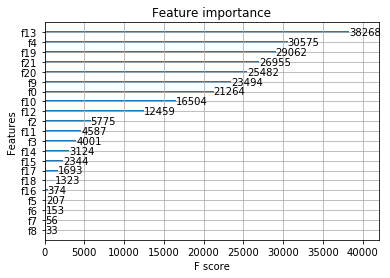

In [5]:
xgb.plot_importance(bst)

## 预测

### 在valid数据集上预测结果

In [2]:
bst = xgb.Booster(model_file="xgb_version2.model")

In [ ]:
# 看一下在valid上的预测效果
pred_valid = bst.predict(dvalid, output_margin = True)
# real_pred_valid = revive_sales(data = X_valid, pred = pred_valid)
real_pred_valid = (np.exp(pred_valid) - 1) #* 0.985
acc = rmspe(real_pred_valid, Y_valid.values)
print("RMSPE准确率为：", acc)

### test数据集预测结果提交kaggle

In [30]:
X_submit = sub_all_data.loc[sub_all_data['Insample'] == 0]
dsubmit = xgb.DMatrix(X_submit[features_x])

ypred_bst = bst.predict(dsubmit)

df_ypred = X_submit['Id'].reset_index()
del df_ypred['index']
df_ypred['Id'] = df_ypred['Id'].astype('int')

# Scale back the sales a bit
df_ypred['Sales'] = (np.exp(ypred_bst) - 1)

df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('./结果提交/submission_version2.csv', index=False)